In [61]:
import matplotlib
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from nilearn import datasets
from nilearn.input_data import NiftiMasker, NiftiSpheresMasker
from nilearn.plotting import plot_roi, plot_epi, show
from nilearn.image.image import mean_img
import nilearn.image as image

In [25]:
dev_data = datasets.fetch_development_fmri(n_subjects=1)
func_filename = dev_data.func[0]

# print basic information on the dataset
print('First functional nifti image (4D) is at: %s' % func_filename)

First functional nifti image (4D) is at: C:\Users\joann/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


In [26]:
#Compute a mask - what's brain and not brain?
#might be used with a bet and without a mask yet 

# As this is raw movie watching based EPI, the background is noisy and we
# cannot rely on the 'background' masking strategy. We need to use the 'epi'
# one

#turns the image into data
nifti_masker = NiftiMasker(standardize=True, mask_strategy='epi',
                           memory="nilearn_cache", memory_level=2,
                           smoothing_fwhm=8)
nifti_masker.fit(func_filename)
mask_img = nifti_masker.mask_img_

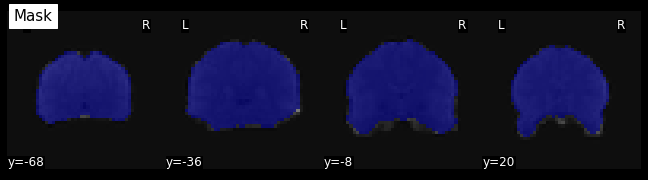

In [27]:
# calculate mean image for the background
mean_func_img = mean_img(func_filename)

plot_roi(mask_img, mean_func_img, display_mode='y', cut_coords=4, title="Mask")

In [28]:
report = nifti_masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,epi
memory,Memory(location=nilearn_cache\joblib)
memory_level,2
reports,True


In [33]:
#fits mask to filename, get it in terms of a 2d matrix

nifti_masker.fit(func_filename)
fmri_masked = nifti_masker.transform(func_filename)
# fmri_masked is now a 2D matrix, (n_voxels x n_time_points)

fmri_masked.shape

(168, 24256)

In [35]:
#use ICA to look at networks within the brain
from sklearn.decomposition import FastICA
n_components = 10 #ask for 10 components 

#this is working on only the data 
ica = FastICA(n_components=n_components, random_state=42)

#give another set of matrices back
# .T).T means transpose the matrix 

#for a network, we want the same number of voxels but a diff number of components
components_masked = ica.fit_transform(fmri_masked.T).T

#this is still a matrix, NOT an image
components_masked

array([[-0.0054228 , -0.0054033 , -0.00659276, ..., -0.00014688,
         0.00248642,  0.00694676],
       [-0.00439959,  0.01741084, -0.00457784, ..., -0.00789593,
        -0.00523883, -0.00076501],
       [-0.00225022,  0.00036421,  0.00021725, ..., -0.00233804,
        -0.0033148 , -0.00514348],
       ...,
       [-0.00521328,  0.00311268, -0.00279398, ...,  0.01039146,
         0.00797135,  0.00348794],
       [ 0.00412078, -0.00282253, -0.00790679, ...,  0.01662247,
         0.01625602,  0.01054243],
       [ 0.00647547,  0.00513437,  0.00371015, ..., -0.00120732,
        -0.00013393,  0.00059647]])

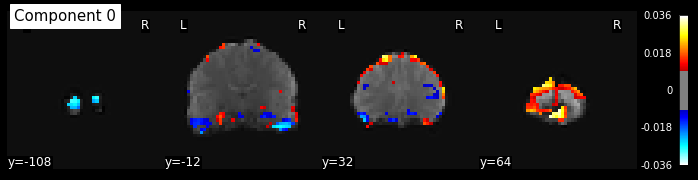

In [39]:
from nilearn.plotting import plot_stat_map
components = nifti_masker.inverse_transform(components_masked)
#puts this back into the space of the brain 

# Visualize results

# calculate mean image for the background

mean_func_img = mean_img(func_filename)

plot_stat_map(image.index_img(components, 0), mean_func_img,
              display_mode='y', cut_coords=4, title="Component 0", threshold = 0.01)

show()


First functional nifti image (4D) is located at: C:\Users\joann/nilearn_data\miyawaki2008\func\data_figure_run01.nii.gz


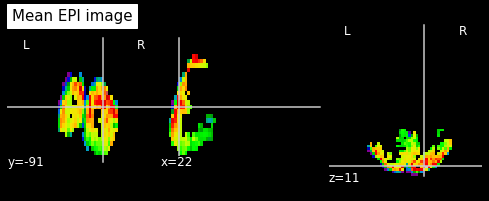

In [40]:
from nilearn import datasets
miyawaki_dataset = datasets.fetch_miyawaki2008()

# print basic information on the dataset
print('First functional nifti image (4D) is located at: %s' %
      miyawaki_dataset.func[0])  # 4D data

miyawaki_filename = miyawaki_dataset.func[0]
miyawaki_mean_img = image.mean_img(miyawaki_filename)
plot_epi(miyawaki_mean_img, title='Mean EPI image')

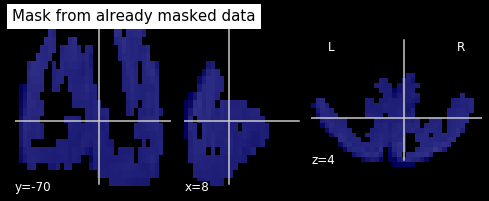

In [41]:
masker = NiftiMasker()
masker.fit(miyawaki_filename)

# Plot the generated mask using the mask_img_ attribute
plot_roi(masker.mask_img_, miyawaki_mean_img,
         title="Mask from already masked data")

In [42]:
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,background
memory,Memory(location=None)
memory_level,1
reports,True


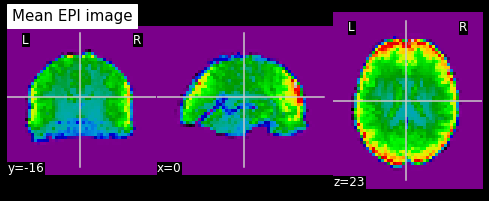

In [14]:
# Load movie watching based brain development fmri dataset
dataset = datasets.fetch_development_fmri(n_subjects=1)
epi_filename = dataset.func[0]

# Restrict to first 100 slices/frames to speed up computation
from nilearn.image import index_img
epi_img = index_img(epi_filename, slice(0, 100))

# To display the background
mean_img = image.mean_img(epi_img)
#this has not been masked
plot_epi(mean_img, title='Mean EPI image')

In [15]:
#tells to fit the bold image and make a mask
masker = NiftiMasker(mask_strategy='epi')
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


In [16]:
#make a smaller opening to cut out more brain imaging 

masker = NiftiMasker(mask_strategy='epi', mask_args=dict(opening=10))
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,{'opening': 10}
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


In [17]:
#this is a little finer around the edges

masker = NiftiMasker(mask_strategy='epi',
                     mask_args=dict(upper_cutoff=.9, lower_cutoff=.8,
                                    opening=False))
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,"{'upper_cutoff': 0.9, 'lower_cutoff': 0.8, 'opening': False}"
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


In [18]:
#use a mask strategy from a template if its already from MNI space
masker = NiftiMasker(mask_strategy='template')
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,template
memory,Memory(location=None)
memory_level,1
reports,True


In [19]:
import numpy as np

masker = NiftiMasker(mask_strategy='epi', target_affine=np.eye(3) * 8)
masker.fit(epi_img)
report = masker.generate_report()
report

Parameter,Value
detrend,False
dtype,None
high_pass,None
low_pass,None
mask_args,None
mask_img,None
mask_strategy,epi
memory,Memory(location=None)
memory_level,1
reports,True


In [43]:
# trended vs detrended
trended = NiftiMasker(mask_strategy='epi')
detrended = NiftiMasker(mask_strategy='epi', detrend=True)
trended_data = trended.fit_transform(epi_img)
detrended_data = detrended.fit_transform(epi_img)

# The timeseries are numpy arrays, so we can manipulate them with numpy

print("Trended: mean %.2f, std %.2f" %
      (np.mean(trended_data), np.std(trended_data)))
print("Detrended: mean %.2f, std %.2f" %
      (np.mean(detrended_data), np.std(detrended_data)))

show()

Trended: mean 552.82, std 168.28
Detrended: mean -0.00, std 5.88


In [44]:
func_filename = dev_data.func[0]
confound_filename = dataset.confounds[0]
print(func_filename)
print(confound_filename)

C:\Users\joann/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
C:\Users\joann/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_desc-reducedConfounds_regressors.tsv


In [45]:
pcc_coords = [(0, -52, 18)]
seed_masker = NiftiSpheresMasker(
    pcc_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

In [46]:
seed_time_series = seed_masker.fit_transform(func_filename,
                                             confounds=[confound_filename])

In [47]:

brain_masker = NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2,
    memory='nilearn_cache', memory_level=1, verbose=0)

brain_time_series = brain_masker.fit_transform(func_filename,
                                               confounds=[confound_filename])

In [48]:
print("Seed time series shape: (%s, %s)" % seed_time_series.shape)
print("Brain time series shape: (%s, %s)" % brain_time_series.shape)

Seed time series shape: (168, 1)
Brain time series shape: (168, 32504)


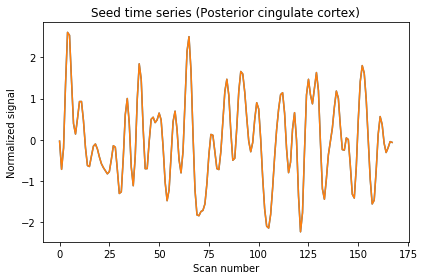

In [49]:
import matplotlib.pyplot as plt

plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()
plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

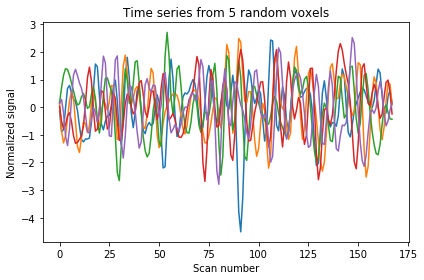

In [50]:
#pick out five random voxels from the brain, they also go up and down like the other graph 
plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [54]:
#use numpy to correlate the brain by seed time series, and divide by shape 
import numpy as np

seed_to_voxel_correlations = (np.dot(brain_time_series.T, seed_time_series) /
                              seed_time_series.shape[0]
                              )

In [52]:
#want a correlation for each voxel, not each time point

print("Seed-to-voxel correlation shape: (%s, %s)" %
      seed_to_voxel_correlations.shape)
print("Seed-to-voxel correlation: min = %.3f; max = %.3f" % (
    seed_to_voxel_correlations.min(), seed_to_voxel_correlations.max()))

Seed-to-voxel correlation shape: (32504, 1)
Seed-to-voxel correlation: min = -0.624; max = 0.958


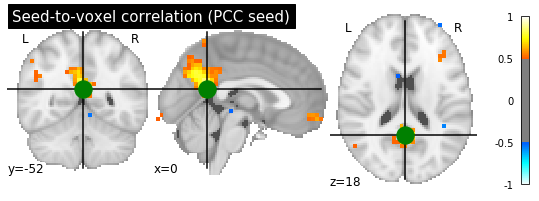

In [55]:
from nilearn import plotting

#going to need to inverse transform bc right now theyre just an array 
seed_to_voxel_correlations_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations.T)
display = plotting.plot_stat_map(seed_to_voxel_correlations_img,
                                 threshold=0.5, vmax=1,
                                 cut_coords=pcc_coords[0],
                                 title="Seed-to-voxel correlation (PCC seed)"
                                 )
display.add_markers(marker_coords=pcc_coords, marker_color='g',
                    marker_size=300)
# At last, we save the plot as pdf.

#the green is our original sphere, the activation is what is highly correlated
display.savefig('pcc_seed_correlation.pdf')

In [58]:
seed_to_voxel_correlations_fisher_z = np.arctanh(seed_to_voxel_correlations)
print("Seed-to-voxel correlation Fisher-z transformed: min = %.3f; max = %.3f"
      % (seed_to_voxel_correlations_fisher_z.min(),
         seed_to_voxel_correlations_fisher_z.max()
         )
      )

# Finally, we can tranform the correlation array back to a Nifti image
# object, that we can save.
seed_to_voxel_correlations_fisher_z_img = brain_masker.inverse_transform(
    seed_to_voxel_correlations_fisher_z.T)
seed_to_voxel_correlations_fisher_z_img.to_filename(
    'pcc_seed_correlation_z.nii.gz')



Seed-to-voxel correlation Fisher-z transformed: min = -0.731; max = 1.927



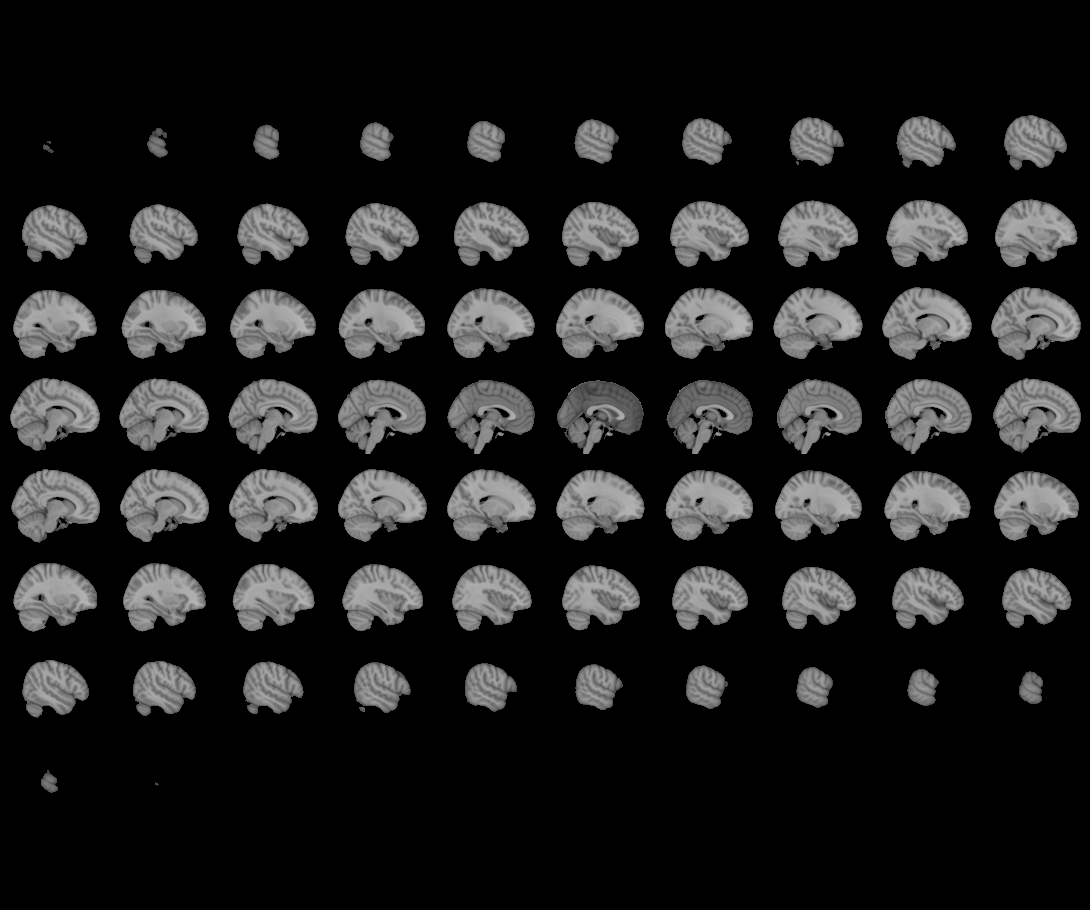
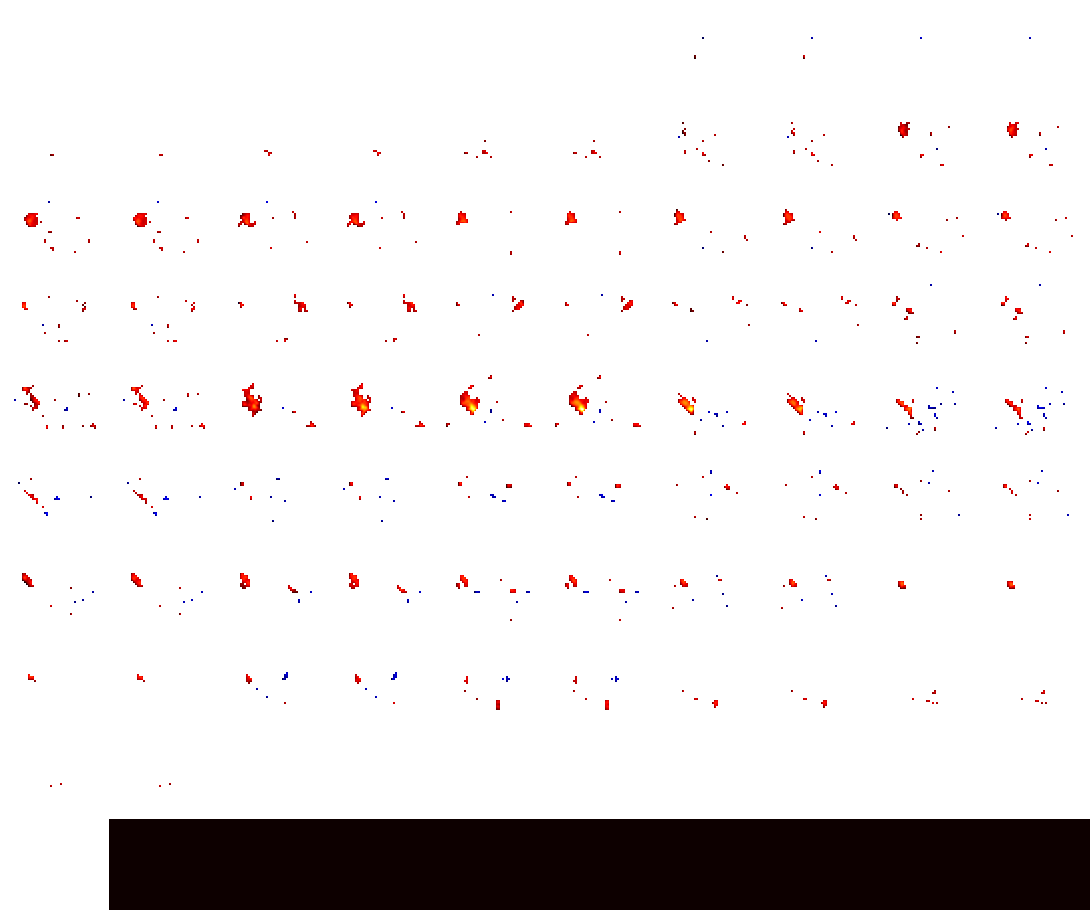

In [60]:
plotting.view_img(seed_to_voxel_correlations_fisher_z_img, threshold=0.5,
                                   title="Correlation Z")

#shows the image as zscores 
#can open this in fsleyes 
